# The QNLP Pipeline for Twitter Sentiment Analysis
## 1. Load the preprocessed data

In [1]:
import collections
import pickle
import warnings
warnings.filterwarnings("ignore")
import os
from random import shuffle
import random
from discopy.tensor import Tensor
from discopy import Word
from discopy.rigid import Functor
from discopy import grammar
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from jax import numpy as np
import numpy
from lambeq import AtomicType, IQPAnsatz, remove_cups, NumpyModel, spiders_reader
from lambeq import BobcatParser, TreeReader, cups_reader, DepCCGParser
from lambeq import Dataset
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import TketModel
from lambeq import Rewriter
from pytket.extensions.qiskit import AerBackend
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.width', 1000)
pd.options.display.max_colwidth=80
print(os.getcwd())
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
BATCH_SIZE = 100
EPOCHS = 100
SEED = 0

TRAIN_INDEX_RATIO = 0.06
VAL_INDEX_RATIO = TRAIN_INDEX_RATIO + 0.01
TEST_INDEX_RATIO = VAL_INDEX_RATIO + 0.01

assert TEST_INDEX_RATIO <= 1

def load_pickled_dict_to_df(filename):
    saved_dict = pickle.load(open(filename, 'rb'))
    df =  pd.DataFrame.from_dict(saved_dict)
    df =  df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    sentiment = []
    for i in df['target']:
        if i == "Positive":
            sentiment.append(1)
        else:
            sentiment.append(0)
    df["Sentiment"] = sentiment
    return df

cleaned_qnlp_filename = os.path.join(os.getcwd(), 'cleaned_qnlp_data.pkl')
cleaned_lemmatized_qnlp_filename = os.path.join(os.getcwd(), 'cleaned_qnlp_data_lematize.pkl')
cleaned_lemmatized_stemmed_qnlp_filename = os.path.join(os.getcwd(), 'cleaned_qnlp_data_stem_lematize.pkl')

cleaned_qnlp = load_pickled_dict_to_df(cleaned_qnlp_filename)

cleaned_lemmatized_qnlp = load_pickled_dict_to_df(cleaned_lemmatized_qnlp_filename)

cleaned__lemmatized_stemmed_qnlp = load_pickled_dict_to_df(cleaned_lemmatized_stemmed_qnlp_filename)

/home/peiyongw/Desktop/Hackathon-QNLP


In [2]:
cleaned_qnlp.head(10)

,data,label,target,Sentiment
0,this isn t one hour i am still crushing all version of combat imperial warfa...,"[0, 1]",Positive,1
1,to my home depot friend this place is very close to work and it is very inex...,"[0, 1]",Positive,1
2,what a cutie unk unk check out my screenshot from world of,"[0, 1]",Positive,1
3,battlefield war v is a boring mess,"[1, 0]",Negative,0
4,the flatline of red dead redemption pic twitter com,"[1, 0]",Negative,0
5,we re back tomorrow from playing fife grinding towards the weekend league we...,"[0, 1]",Positive,1
6,plus pubg wa the only game in this a serious and also stressful condition of...,"[0, 1]",Positive,1
7,hi s i lost two hour of progress in southern borderland again how is everyone,"[1, 0]",Negative,0
8,film canon r uhd film nvidia,"[0, 1]",Positive,1
9,is there a chance we also can get some more awesome package too because here...,"[1, 0]",Negative,0


In [3]:
cleaned_qnlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4084 entries, 0 to 4083
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       4084 non-null   object
 1   label      4084 non-null   object
 2   target     4084 non-null   object
 3   Sentiment  4084 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 127.8+ KB


<AxesSubplot:xlabel='target', ylabel='count'>

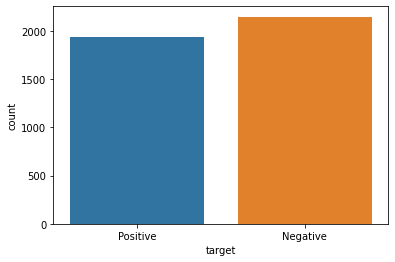

In [4]:
sns.countplot(x = "target", data = cleaned_qnlp)

In [5]:
cleaned_lemmatized_qnlp.head(10)

,data,label,target,Sentiment
0,this isn t one hour i am still crushing all version of combat imperial warfa...,"[0, 1]",Positive,1
1,to my home depot friend this place is very close to work and it is very inex...,"[0, 1]",Positive,1
2,what a cutie unk unk check out my screenshot from world of,"[0, 1]",Positive,1
3,battlefield war v is a boring mess,"[1, 0]",Negative,0
4,the flatline of red dead redemption pic twitter com,"[1, 0]",Negative,0
5,we re back tomorrow from playing fife grinding towards the weekend league we...,"[0, 1]",Positive,1
6,plus pubg wa the only game in this a serious and also stressful condition of...,"[0, 1]",Positive,1
7,hi s i lost two hour of progress in southern borderland again how is everyone,"[1, 0]",Negative,0
8,film canon r uhd film nvidia,"[0, 1]",Positive,1
9,is there a chance we also can get some more awesome package too because here...,"[1, 0]",Negative,0


In [6]:
cleaned_lemmatized_qnlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4084 entries, 0 to 4083
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       4084 non-null   object
 1   label      4084 non-null   object
 2   target     4084 non-null   object
 3   Sentiment  4084 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 127.8+ KB


<AxesSubplot:xlabel='target', ylabel='count'>

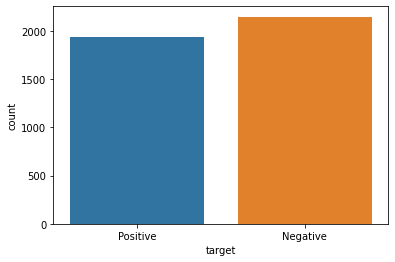

In [7]:
sns.countplot(x='target', data = cleaned_lemmatized_qnlp)

In [8]:
cleaned__lemmatized_stemmed_qnlp.head(10)

,data,label,target,Sentiment
0,i realli don t know whi i play fortnit it is so bad,"[0, 1]",Positive,1
1,fantast day today congratul to gearboxoffici and borderland stori make you f...,"[0, 1]",Positive,1
2,microsoft had a major outag today,"[1, 0]",Negative,0
3,thi wa better,"[1, 0]",Negative,0
4,p the player are part of own observ no wonder they are back to work,"[1, 0]",Negative,0
5,nice e gaben veri nice,"[0, 1]",Positive,1
6,first red dead redempt end got me in my feel what a masterpiec by moonlight,"[0, 1]",Positive,1
7,whi can t i play red dead redempt onlin error,"[1, 0]",Negative,0
8,it s amaz how mani game of c go you can win when mrbaconthoma actual tri,"[0, 1]",Positive,1
9,great deal fifa ebay com rover,"[0, 1]",Positive,1


In [9]:
cleaned__lemmatized_stemmed_qnlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4084 entries, 0 to 4083
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       4084 non-null   object
 1   label      4084 non-null   object
 2   target     4084 non-null   object
 3   Sentiment  4084 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 127.8+ KB


<AxesSubplot:xlabel='target', ylabel='count'>

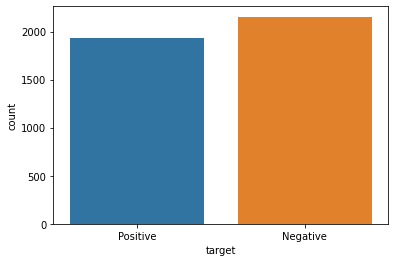

In [10]:
sns.countplot(x='target', data = cleaned__lemmatized_stemmed_qnlp)

## 2. Train QNLP Models for Different-Preprocessed Data
Since the limited parsing and training speed using on the CPU, we'll only use a fraction of our data.

In [11]:
parser = BobcatParser(verbose='text')
# parser = DepCCGParser(root_cats=['S[dcl]'])
# parser = cups_reader
NUM_DATA = 4084

loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
rewriter = Rewriter(['prepositional_phrase', 'determiner', 'auxiliary', 'connector', 
                         'coordination', 'object_rel_pronoun', 'subject_rel_pronoun',
                        'postadverb', 'preadverb'])
def rewrite(diagram):
    # diagram = rewriter(diagram)
    return remove_cups(diagram)

def create_diagrams_and_labels(total_df):
    total_text = total_df['data'].tolist()
    total_labels = total_df["Sentiment"].tolist()
    total_labels = [[t, 1-t] for t in total_labels] # [1, 0] for positive, [0, 1] for negative
    train_diagrams = parser.sentences2diagrams(total_text[:round(NUM_DATA*TRAIN_INDEX_RATIO)])
    train_labels = total_labels[:round(NUM_DATA*TRAIN_INDEX_RATIO)]
    dev_diagrams = parser.sentences2diagrams(total_text[round(NUM_DATA*TRAIN_INDEX_RATIO):round(NUM_DATA*VAL_INDEX_RATIO)])
    dev_labels = total_labels[round(NUM_DATA*TRAIN_INDEX_RATIO):round(NUM_DATA*VAL_INDEX_RATIO)]
    test_diagrams = parser.sentences2diagrams(total_text[round(NUM_DATA*VAL_INDEX_RATIO):round(NUM_DATA*TEST_INDEX_RATIO)])
    test_labels = total_labels[round(NUM_DATA*VAL_INDEX_RATIO):round(NUM_DATA*TEST_INDEX_RATIO)]
    
    return train_diagrams, train_labels, dev_diagrams, dev_labels, test_diagrams, test_labels

Extracting model...


### 2.1 Data without Lemmatization or Stemming
#### 2.1.1 Create diagrams

In [ ]:
raw_train_diagrams_1, train_labels_1, raw_dev_diagrams_1, dev_labels_1, raw_test_diagrams_1, test_labels_1 = create_diagrams_and_labels(cleaned_qnlp)
print(len(raw_train_diagrams_1))

Tagging sentences.
Parsing tagged sentences.


In [ ]:
grammar.draw(raw_train_diagrams_1[8],figsize=(12,3), fontsize=12)

#### 2.1.2 Simplify the diagrams

In [ ]:
train_diagrams_1 = [rewrite(diagram) for diagram in raw_train_diagrams_1]
dev_diagrams_1 = [rewrite(diagram) for diagram in raw_dev_diagrams_1]
test_diagrams_1 = [rewrite(diagram) for diagram in raw_test_diagrams_1]

In [ ]:
train_diagrams_1[8].draw(figsize=(6,5))

#### 2.1.3 Create circuits

In [ ]:
ansatz_1 = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1, AtomicType.NOUN_PHRASE:1, AtomicType.CONJUNCTION:1}, n_layers=1, n_single_qubit_params=3)
train_circuits_1 = [ansatz_1(diagram) for diagram in train_diagrams_1]
dev_circuits_1 =  [ansatz_1(diagram) for diagram in dev_diagrams_1]
test_circuits_1 = [ansatz_1(diagram) for diagram in test_diagrams_1]

In [ ]:
train_circuits_1[8].draw(figsize=(9, 12))

#### 2.1.4 Parameterise

In [ ]:
all_circuits_1 = train_circuits_1 + dev_circuits_1 + test_circuits_1
backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 2048
}
model_1 = NumpyModel.from_diagrams(all_circuits_1, use_jit=True)
# model_1 = TketModel.from_diagrams(all_circuits_1, backend_config=backend_config)

#### 2.1.5 Initialize trainer

In [ ]:
trainer_1 = QuantumTrainer(
    model_1,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)
train_dataset_1 = Dataset(
            train_circuits_1,
            train_labels_1,
            batch_size=BATCH_SIZE)

val_dataset_1 = Dataset(dev_circuits_1, dev_labels_1, shuffle=False)

#### 2.1.6 Train

In [ ]:
trainer_1.fit(train_dataset_1, val_dataset_1, logging_step=1)

#### 2.1.7 Show Results

In [ ]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(12, 8))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer_1.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer_1.train_results['acc'], color=next(colours))
ax_tr.plot(trainer_1.val_costs, color=next(colours))
ax_br.plot(trainer_1.val_results['acc'], color=next(colours))

test_acc_1 = acc(model_1(test_circuits_1), test_labels_1)
print('Test accuracy:', test_acc_1)